In [1]:
import sys
import os
import pathlib
import glob
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from dateutil import parser
# from datetime import datetime, timedelta

import matplotlib.pyplot as plt
# import seaborn as sns
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [32]:
%load_ext autoreload
%autoreload 2
from helper_functions import epa_taiwan_data_pipeline

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

In [2]:
root_dir = pathlib.Path(os.getcwd()).parent
raw_data_dir = root_dir / "data/0_raw"
processed_data_dir = root_dir / "data/1_processed"
experiment_dir = root_dir / "experiment"

# Data Loading and Preprocessing

- Import the data
- Preprocess the data
- Turn the data into tensor

In [44]:
year = 2018
site_name = "Banqiao"
columns = ["SiteEngName","PM2.5","AMB_TEMP","CH4",'CO',"NMHC","read_time"]

# import data
pm25_df = epa_taiwan_data_pipeline.import_epa_data(site_name=site_name, year=year)

# basic preprocessing
pm25_df = epa_taiwan_data_pipeline.standardize_df(pm25_df)

In [45]:
# make sure the time diff is always constant
pm25_df['time_diff'] = pm25_df['read_time'].diff()
time_diff_list = pm25_df['time_diff'].unique().dropna()

if len(time_diff_list) > 1:
    print(f"{time_diff_list.unique()}")
else:
    print(f"time difference is always: {time_diff_list[0]}")
    pm25_df = pm25_df.drop(columns=["time_diff"])
    pm25_df.head()

time difference is always: 0 days 01:00:00


## Plot

We want to see through the plots if there's any noticable pattern on our data

### Overall Plot

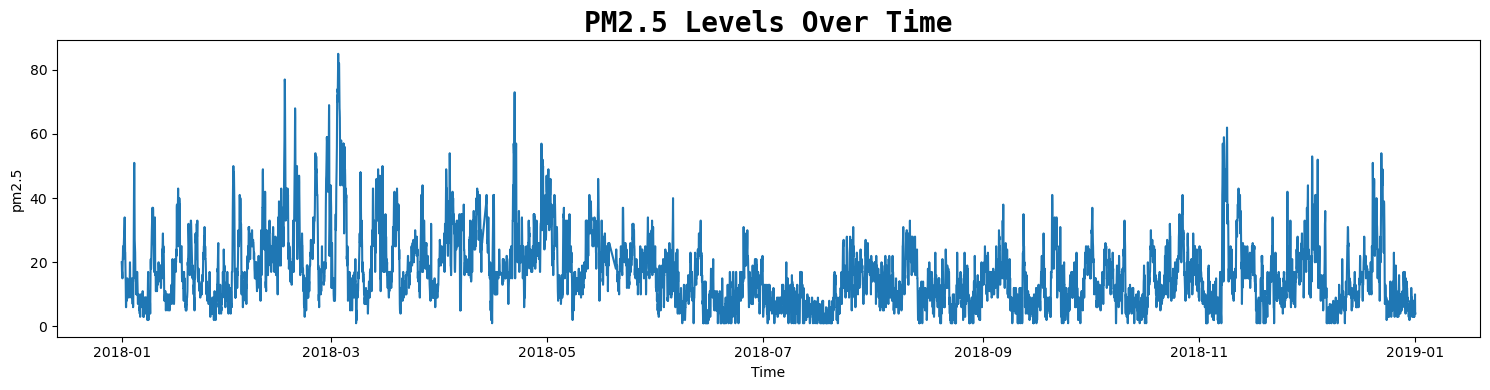

In [53]:
# col_to_plot = pm25_df.columns[1:-1]
col_to_plot = [pm25_df.columns[1]]

nrow = len(col_to_plot)
ncols = 1

fig, ax = plt.subplots(
    nrow,
    ncols,
    figsize = (15,4*nrow)
    )

try:
    for col, ax in zip(col_to_plot, ax.flatten()):
        ax.plot(
            pm25_df['read_time'], 
            pm25_df[col],
            linestyle='-',
            )
        ax.set_title(f'{col.upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{col}')
except:
    ax.plot(
        pm25_df['read_time'], 
        pm25_df[col_to_plot[0]],
        linestyle='-',
        )
    ax.set_title(f'{col_to_plot[0].upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{col_to_plot[0]}')
    
plt.tight_layout()

### Daily Plot

In [56]:
# pm25_df["read_time"].dt.date.unique()

In [ ]:
# col_to_plot = pm25_df.columns[1:-1]
col_to_plot = [pm25_df.columns[1]]

nrow = len(col_to_plot)
ncols = 1

fig, ax = plt.subplots(
    nrow,
    ncols,
    figsize = (15,4*nrow)
    )

start_date = 
end_date = 

try:
    for col, ax in zip(col_to_plot, ax.flatten()):
        ax.plot(
            pm25_df['read_time'], 
            pm25_df[col],
            linestyle='-',
            )
        ax.set_title(f'{col.upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
        ax.set_xlabel('Time')
        ax.set_ylabel(f'{col}')
except:
    ax.plot(
        pm25_df['read_time'], 
        pm25_df[col_to_plot[0]],
        linestyle='-',
        )
    ax.set_title(f'{col_to_plot[0].upper()} Levels Over Time', fontweight = "bold", fontsize = 20, fontfamily = "monospace")
    ax.set_xlabel('Time')
    ax.set_ylabel(f'{col_to_plot[0]}')
    
plt.tight_layout()

### Weekly Plot

### Monthly Plot

## Feature Engineering

# Training Pipeline

- Prepare the model
- Initiate loss and optimization function
- Training process
- Plot the loss curve

# Experimentation

- Prepare different scenario
- Log the experiment
- Monitor the result with MLFlow or tensorboard

# Inferencing

- Load the best model
- Prepare the test data
- Save the result

# Deployment